In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../pytools')
import d2l

d2l.gpu_mem_init()

2025-09-11 14:02:46.050458: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 14:02:46.113290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-11 14:02:47.618144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
n_train,n_test,num_inputs,batch_size = 20, 100, 200, 5
true_w,true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.construct_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size, n_train)
train_iter0 = d2l.load_array(train_data, batch_size, n_train)
test_data = d2l.construct_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, n_test)
test_iter0 = d2l.load_array(test_data, batch_size, n_test)

I0000 00:00:1757570568.584049 1449032 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31135 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0


In [3]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=0.0, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1,)))
    return [w, b]

In [4]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

In [5]:
def train(lambd):
    w,b = init_params()
    loss = d2l.squared_loss
    net = lambda X: d2l.linreg(X, w, b)
    optimizer = d2l.sgd
    num_epochs,lr = 100,0.03
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for x,y in train_iter:
            with tf.GradientTape() as t:
                l = loss(net(x), y) + l2_penalty(w) * lambd
            grads = t.gradient(l, [w,b])
            optimizer([w,b], grads, lr, batch_size)
            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', tf.norm(w).numpy())


w的L2范数是： 13.807077


2025-09-11 14:03:07.503873: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


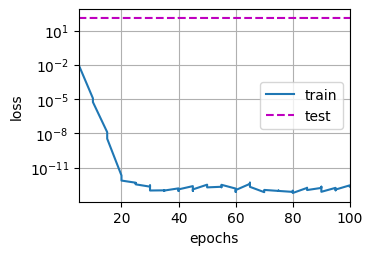

In [6]:
train(lambd=0)

w的L2范数是： 0.03230038


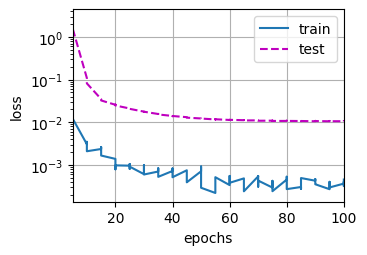

In [7]:
train(lambd=3)

In [8]:
def train_concise(wd):
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(wd)))
    net.build(input_shape=(1, num_inputs))
    w, b = net.trainable_variables
    loss = tf.keras.losses.MeanSquaredError()
    num_epochs,lr = 100,0.003
    optimer = tf.keras.optimizers.SGD(learning_rate=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for x,y in train_iter0:
            with tf.GradientTape() as t:
                l = loss(net(x), y) + net.losses
            grads = t.gradient(l, net.trainable_variables)
            optimer.apply_gradients(zip(grads, net.trainable_variables))
            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter0, loss),
                                     d2l.evaluate_loss(net, test_iter0, loss)))
    print('w的L2范数：', tf.norm(net.get_weights()[0]).numpy())

w的L2范数： 1.2743001


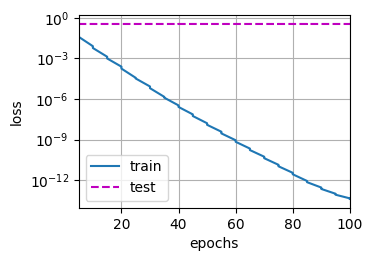

In [9]:
train_concise(wd=0)

w的L2范数： 0.031023134


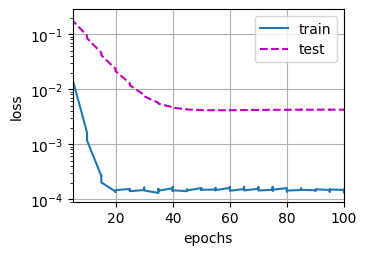

In [10]:
train_concise(wd=3)